<a href="https://colab.research.google.com/github/BrayanArismendi1997/Proyecto-Data-Scientist/blob/main/Pron%C3%B3stico_1_1_DL_RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
%pip install skforecast

In [24]:
%pip install tensorflow

In [25]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import tensorflow
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.style.use('ggplot')

import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.ForecasterRnn import ForecasterRnn
from skforecast.ForecasterRnn.utils import create_and_compile_model
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('once')

print(f"skforecast version: {skforecast.__version__}")
print(f"tensorflow version: {tensorflow.__version__}")

skforecast version: 0.12.1
tensorflow version: 2.15.0


In [26]:
# Data download
# ==============================================================================
air_quality = fetch_dataset(name="air_quality_valencia")
#https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast-datasets/main/data/air_quality_valencia.csv


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


air_quality_valencia
--------------------
Hourly measures of several air quimical pollutant (pm2.5, co, no, no2, pm10,
nox, o3, so2) at Valencia city.
 Red de Vigilancia y Control de la Contaminación Atmosférica, 46250054-València
- Centre, https://mediambient.gva.es/es/web/calidad-ambiental/datos-historicos.
Shape of the dataset: (26304, 10)


In [27]:
# Data preparation
# ==============================================================================
air_quality = air_quality.interpolate(method="linear")
air_quality = air_quality.sort_index()
air_quality

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,pm2.5,co,no,no2,pm10,nox,o3,veloc.,direc.,so2
datetime,,,,,,,,,,
2019-01-01 00:00:00,19.0,0.2,3.0,36.0,22.0,40.0,16.0,0.5,262.0,8.0
2019-01-01 01:00:00,26.0,0.1,2.0,40.0,32.0,44.0,6.0,0.6,248.0,8.0
2019-01-01 02:00:00,31.0,0.1,11.0,42.0,36.0,58.0,3.0,0.3,224.0,8.0
2019-01-01 03:00:00,30.0,0.1,15.0,41.0,35.0,63.0,3.0,0.2,220.0,10.0
2019-01-01 04:00:00,30.0,0.1,16.0,39.0,36.0,63.0,3.0,0.4,221.0,11.0
...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,31.0,0.1,20.0,36.0,34.0,66.0,13.0,0.1,87.0,3.0
2021-12-31 20:00:00,33.0,0.1,25.0,38.0,39.0,75.0,13.0,0.1,67.0,4.0
2021-12-31 21:00:00,34.0,0.1,24.0,36.0,42.0,73.0,13.0,0.1,84.0,5.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='datetime'>

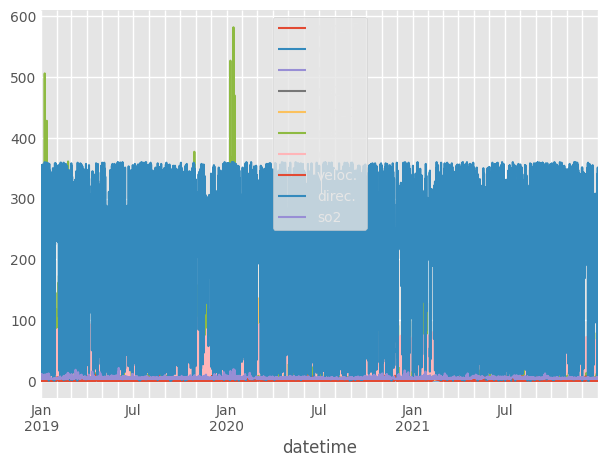

In [28]:
air_quality.plot()

In [29]:
air_quality.describe()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,pm2.5,co,no,no2,pm10,nox,o3,veloc.,direc.,so2
count,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000
mean,9.055809,0.137357,4.578182,16.762280,15.683698,23.616408,54.517469,1.505271,164.917522,4.018381
std,8.466350,0.070458,12.666994,15.775873,15.865960,31.056620,26.830350,1.495544,102.091508,1.405008
min,1.000000,0.100000,1.000000,1.000000,1.000000,2.000000,3.000000,0.100000,0.000000,3.000000
25%,3.000000,0.100000,1.000000,6.000000,6.000000,8.000000,36.000000,0.400000,71.000000,3.000000
50%,6.000000,0.100000,2.000000,12.000000,11.000000,14.000000,56.000000,1.000000,139.000000,3.000000
75%,11.742475,0.200000,2.000000,22.000000,21.000000,26.000000,74.000000,2.200000,248.000000,5.000000
max,109.000000,1.500000,325.000000,149.000000,322.000000,582.000000,139.000000,12.900000,360.000000,21.000000


In [30]:
air_quality.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26304 entries, 2019-01-01 00:00:00 to 2021-12-31 23:00:00
Freq: H
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pm2.5   26304 non-null  float64
 1   co      26304 non-null  float64
 2   no      26304 non-null  float64
 3   no2     26304 non-null  float64
 4   pm10    26304 non-null  float64
 5   nox     26304 non-null  float64
 6   o3      26304 non-null  float64
 7   veloc.  26304 non-null  float64
 8   direc.  26304 non-null  float64
 9   so2     26304 non-null  float64
dtypes: float64(10)
memory usage: 2.2 MB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
# Checking the frequency of the time series
# ==============================================================================
print(f"Index: {air_quality.index.dtype}")
print(f"Frequency: {air_quality.index.freq}")

Index: datetime64[ns]
Frequency: <Hour>


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
# Calcular los índices para los splits
n = len(air_quality)
train_end_idx = int(n * 0.6)
val_end_idx = int(n * 0.8)

# Split de los datos
air_quality_train = air_quality.iloc[:train_end_idx, :].copy()
air_quality_val = air_quality.iloc[train_end_idx:val_end_idx, :].copy()
air_quality_test = air_quality.iloc[val_end_idx:, :].copy()

# Imprimir los rangos de fechas y la cantidad de datos en cada conjunto
print(
    f"Dates train      : {air_quality_train.index.min()} --- "
    f"{air_quality_train.index.max()}  (n={len(air_quality_train)})"
)
print(
    f"Dates validation : {air_quality_val.index.min()} --- "
    f"{air_quality_val.index.max()}  (n={len(air_quality_val)})"
)
print(
    f"Dates test       : {air_quality_test.index.min()} --- "
    f"{air_quality_test.index.max()}  (n={len(air_quality_test)})"
)

end_train = {air_quality_train.index.max()}
end_validation = {air_quality_test.index.max()}


Dates train      : 2019-01-01 00:00:00 --- 2020-10-19 13:00:00  (n=15782)
Dates validation : 2020-10-19 14:00:00 --- 2021-05-26 18:00:00  (n=5261)
Dates test       : 2021-05-26 19:00:00 --- 2021-12-31 23:00:00  (n=5261)


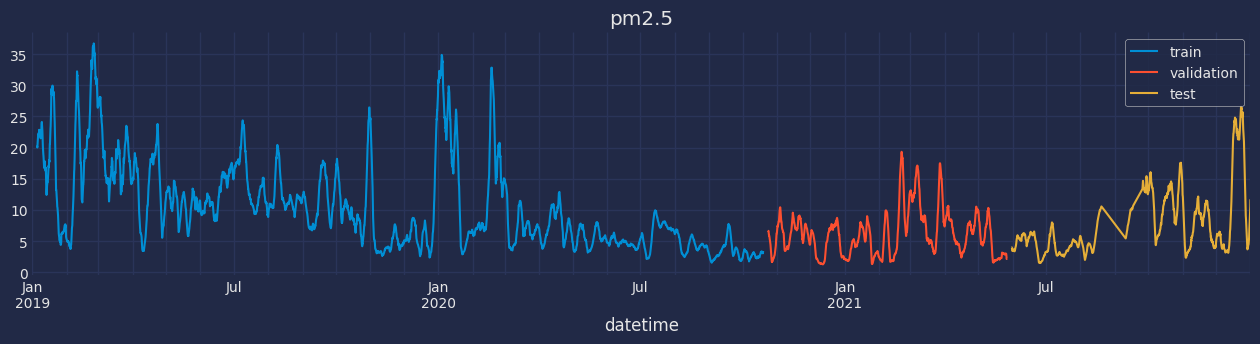

In [33]:
# Plotting one feature
# ==============================================================================
set_dark_theme()
fig, ax = plt.subplots(figsize=(14, 3))
air_quality_train["pm2.5"].rolling(100).mean().plot(ax=ax, label="train")
air_quality_val["pm2.5"].rolling(100).mean().plot(ax=ax, label="validation")
air_quality_test["pm2.5"].rolling(100).mean().plot(ax=ax, label="test")
ax.set_title("pm2.5")
ax.legend();

#Pronóstico de un solo paso 1:1: prediga un paso por delante de una sola serie utilizando la misma serie como predictor.

In [34]:
# Create model
# ==============================================================================
series = ["o3"] # Series used as predictors
levels = ["o3"] # Target serie to predict
lags = 32 # Past time steps to be used to predict the target
steps = 1 # Future time steps to be predicted

data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels,
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=4,
    dense_units=16,
    optimizer=Adam(learning_rate=0.01),
    loss=MeanSquaredError()
)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 4)                 96        
                                                                 
 dense_2 (Dense)             (None, 16)                80        


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
 reshape_1 (Reshape)         (None, 1, 1)              0         
                                                                 
Total params: 193 (772.00 Byte)
Trainable params: 193 (772.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
# Forecaster Definition
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 10,  # Number of epochs to train the model.
        "batch_size": 32,  # Batch size to train the model.
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=5)
        ],  # Callback to stop training when it is no longer learning.
        "series_val": data_val,  # Validation data for model training.
    },
)

forecaster

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:222: UserWarning: Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:252: UserWarning: `steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.
  warnings.warn(


ForecasterRnn 
Regressor: <keras.src.engine.functional.Functional object at 0x7dbf69d40280> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Transformer for series: MinMaxScaler() 
Window size: 32 
Target series, levels: ['o3'] 
Multivariate series (names): None 
Maximum steps predicted: [1] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'model_1', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 32, 1), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_2'}, 'registered_name': None, 'name': 'input_2', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_1', 'trainable': True, 'dtype': 'float32', 'return_sequences': False, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'time_major': False, 'units': 4

In [36]:
# Fit forecaster
# ==============================================================================
forecaster.fit(data_train)

Epoch 1/10
493/493 [==============================] - 9s 15ms/step - loss: 0.0170 - val_loss: 0.0066
Epoch 2/10
493/493 [==============================] - 6s 12ms/step - loss: 0.0060 - val_loss: 0.0063
Epoch 3/10
493/493 [==============================] - 7s 15ms/step - loss: 0.0060 - val_loss: 0.0062
Epoch 4/10
493/493 [==============================] - 6s 12ms/step - loss: 0.0059 - val_loss: 0.0065
Epoch 5/10
493/493 [==============================] - 7s 15ms/step - loss: 0.0058 - val_loss: 0.0061
Epoch 6/10
493/493 [==============================] - 6s 13ms/step - loss: 0.0058 - val_loss: 0.0075
Epoch 7/10
493/493 [==============================] - 7s 15ms/step - loss: 0.0060 - val_loss: 0.0061
Epoch 8/10
493/493 [==============================] - 6s 12ms/step - loss: 0.0059 - val_loss: 0.0064
Epoch 9/10
493/493 [==============================] - 8s 15ms/step - loss: 0.0058 - val_loss: 0.0065
Epoch 10/10
493/493 [==============================] - 6s 12ms/step - loss: 0.0057 - val_lo

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


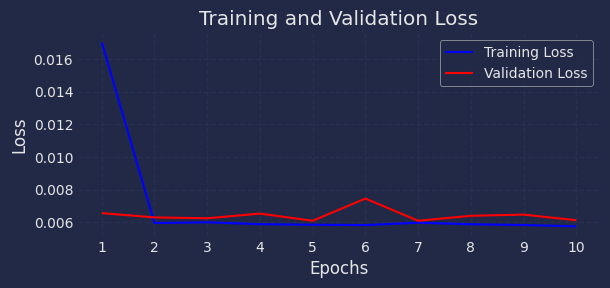

In [37]:
# Track training and overfitting
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
forecaster.plot_history(ax=ax)

In [38]:
# Predictions
# ==============================================================================
predictions = forecaster.predict()
predictions

,o3
2020-10-19 14:00:00,84.42189


In [40]:
# Suponiendo que 'end_validation' es un conjunto que contiene un solo Timestamp:
end_validation = list(end_validation)[0]
end_train=list(end_train)[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
# Backtesting with test data
#El objetivo es evaluar cómo habría funcionado la estrategia o el modelo en el pasado, antes de aplicarlo a datos futuros o en tiempo real.
# ==============================================================================
metrics, predictions2 = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    steps=forecaster.max_step,
    series=data,
    levels=forecaster.levels,
    initial_train_size=val_end_idx, # Training + Validation Data
    metric="mean_absolute_error",
    verbose=False, # Set to True to print detailed information
    refit=False,
)

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


Epoch 1/10
657/657 [==============================] - 11s 15ms/step - loss: 0.0054 - val_loss: 0.0060
Epoch 2/10
657/657 [==============================] - 9s 14ms/step - loss: 0.0053 - val_loss: 0.0063
Epoch 3/10
657/657 [==============================] - 8s 12ms/step - loss: 0.0053 - val_loss: 0.0068
Epoch 4/10
657/657 [==============================] - 9s 14ms/step - loss: 0.0053 - val_loss: 0.0072
Epoch 5/10
657/657 [==============================] - 10s 15ms/step - loss: 0.0054 - val_loss: 0.0062
Epoch 6/10
657/657 [==============================] - 9s 14ms/step - loss: 0.0054 - val_loss: 0.0060


  0%|          | 0/5261 [00:00<?, ?it/s]

In [43]:
# Backtesting predictions
# ==============================================================================
predictions2

,o3
2021-05-26 19:00:00,64.404427
2021-05-26 20:00:00,71.484573
2021-05-26 21:00:00,58.938049
2021-05-26 22:00:00,74.531693
2021-05-26 23:00:00,63.413624
...,...
2021-12-31 19:00:00,17.075161
2021-12-31 20:00:00,15.787668
2021-12-31 21:00:00,16.633451
2021-12-31 22:00:00,16.353460


In [46]:
metrics

,levels,mean_absolute_error
0,o3,6.839546


In [45]:
# % Error vs series mean

# ==============================================================================
rel_mse = 100 * metrics.loc[0, 'mean_absolute_error'] / np.mean(data["o3"])
print(f"Serie mean: {np.mean(data['o3']):0.2f}")
print(f"Relative error (mae): {rel_mse:0.2f} %")


Serie mean: 54.52
Relative error (mae): 12.55 %


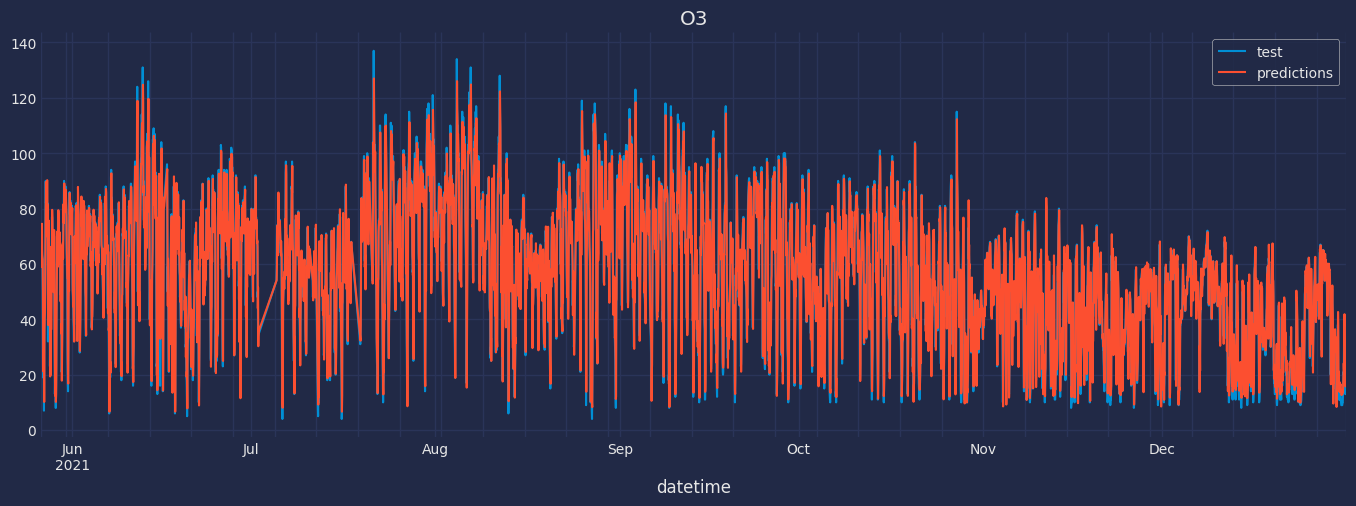

In [50]:
# Plotting predictions vs real values in the test set
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 5))
data_test["o3"].plot(ax=ax, label="test")
predictions["o3"].plot(ax=ax, label="predictions")
ax.set_title("O3")
ax.legend();